## Loading packages

In [43]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

In [69]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

## Training model for the first store/product pair

In [70]:
store_id = 0
product_id = 0

In [71]:
# Filter data for current pair
train_pair = train[(train['store'] == store_id) & (train['product'] == product_id)].copy()
test_pair = test[(test['store'] == store_id) & (test['product'] == product_id)].copy()

# Rename for Prophet
train_pair = train_pair.rename(columns={'Date': 'ds', 'number_sold': 'y'})

# Train/validation split
validation_start = pd.to_datetime('2018-01-01')
train_data = train_pair[train_pair['ds'] < validation_start]
val_data = train_pair[train_pair['ds'] >= validation_start]

In [72]:
best_rmse = float('inf')
best_model = None

param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False],
}

param_samples = list(ParameterSampler(param_grid, n_iter=12, random_state=42))

In [73]:
for params in param_samples:
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        weekly_seasonality=params['weekly_seasonality'],
        yearly_seasonality=params['yearly_seasonality'],
    )

    try:
        model.fit(train_data)

        # Predict validation period
        future_val = val_data[['ds']]
        forecast_val = model.predict(future_val)
        y_pred = forecast_val['yhat'].values
        y_true = val_data['y'].values

        rmse = mean_squared_error(y_true, y_pred, squared=False)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    except Exception as e:
        continue

15:18:49 - cmdstanpy - INFO - Chain [1] start processing
15:18:49 - cmdstanpy - INFO - Chain [1] done processing
15:18:50 - cmdstanpy - INFO - Chain [1] start processing
15:18:50 - cmdstanpy - INFO - Chain [1] done processing
15:18:51 - cmdstanpy - INFO - Chain [1] start processing
15:18:51 - cmdstanpy - INFO - Chain [1] done processing
15:18:52 - cmdstanpy - INFO - Chain [1] start processing
15:18:52 - cmdstanpy - INFO - Chain [1] done processing
15:18:53 - cmdstanpy - INFO - Chain [1] start processing
15:18:54 - cmdstanpy - INFO - Chain [1] done processing
15:18:54 - cmdstanpy - INFO - Chain [1] start processing
15:18:55 - cmdstanpy - INFO - Chain [1] done processing
15:18:56 - cmdstanpy - INFO - Chain [1] start processing
15:18:56 - cmdstanpy - INFO - Chain [1] done processing
15:18:57 - cmdstanpy - INFO - Chain [1] start processing
15:18:58 - cmdstanpy - INFO - Chain [1] done processing
15:18:59 - cmdstanpy - INFO - Chain [1] start processing
15:19:00 - cmdstanpy - INFO - Chain [1]

In [75]:
best_model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        weekly_seasonality=best_params['weekly_seasonality'],
        yearly_seasonality=best_params['yearly_seasonality'],
    )

best_model.fit(train_pair)

In [77]:
future_test = test_pair[['Date']].rename(columns={'Date': 'ds'}).drop_duplicates()
forecast_test = best_model.predict(future_test)
forecast_test = forecast_test[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'predicted_number_sold'})

forecast_test['store'] = store_id
forecast_test['product'] = product_id

# Join with original test to preserve structure
merged = test_pair.merge(forecast_test, on=['Date', 'store', 'product'], how='left')

In [78]:
best_rmse

10.648857988143005

In [79]:
mean_squared_error(merged['number_sold'], merged['predicted_number_sold'], squared=False)

12.224375460275251

## Looping through every store/product pair

In [85]:
# Store predictions
all_forecasts = []

# Define hyperparameter space
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False],
}

# Sample combinations
param_samples = list(ParameterSampler(param_grid, n_iter=12, random_state=42))

# Unique (store, product) pairs
pairs = train[['store', 'product']].drop_duplicates()

# Loop through each pair
for _, row in tqdm(pairs.iterrows(), total=len(pairs)):
    store_id = row['store']
    product_id = row['product']

    # Filter data for current pair
    train_pair = train[(train['store'] == store_id) & (train['product'] == product_id)].copy()
    test_pair = test[(test['store'] == store_id) & (test['product'] == product_id)].copy()

    # Rename for Prophet
    train_pair = train_pair.rename(columns={'Date': 'ds', 'number_sold': 'y'})

    # Train/validation split
    validation_start = pd.to_datetime('2018-01-01')
    train_data = train_pair[train_pair['ds'] < validation_start]
    val_data = train_pair[train_pair['ds'] >= validation_start]

    best_rmse = float('inf')
    best_model = None

    # Try each parameter set
    for params in param_samples:
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            weekly_seasonality=params['weekly_seasonality'],
            yearly_seasonality=params['yearly_seasonality'],
        )

        try:
            model.fit(train_data)

            # Predict validation period
            future_val = val_data[['ds']]
            forecast_val = model.predict(future_val)
            y_pred = forecast_val['yhat'].values
            y_true = val_data['y'].values

            rmse = mean_squared_error(y_true, y_pred, squared=False)

            if rmse < best_rmse:
                best_rmse = rmse
                best_params = params

        except Exception as e:
            continue
            
    best_model = Prophet(
            changepoint_prior_scale=best_params['changepoint_prior_scale'],
            weekly_seasonality=best_params['weekly_seasonality'],
            yearly_seasonality=best_params['yearly_seasonality'],
        )

    best_model.fit(train_pair)

    # Forecast on test period (2019)
    future_test = test_pair[['Date']].rename(columns={'Date': 'ds'}).drop_duplicates()
    forecast_test = best_model.predict(future_test)
    forecast_test = forecast_test[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'predicted_number_sold'})

    forecast_test['store'] = store_id
    forecast_test['product'] = product_id

    # Join with original test to preserve structure
    merged = test_pair.merge(forecast_test, on=['Date', 'store', 'product'], how='left')
    all_forecasts.append(merged)

# Combine all
final_result = pd.concat(all_forecasts)
final_result = final_result[['Date', 'store', 'product', 'number_sold', 'predicted_number_sold']]

  0%|                                                                                           | 0/70 [00:00<?, ?it/s]15:26:15 - cmdstanpy - INFO - Chain [1] start processing
15:26:15 - cmdstanpy - INFO - Chain [1] done processing
15:26:16 - cmdstanpy - INFO - Chain [1] start processing
15:26:16 - cmdstanpy - INFO - Chain [1] done processing
15:26:17 - cmdstanpy - INFO - Chain [1] start processing
15:26:17 - cmdstanpy - INFO - Chain [1] done processing
15:26:18 - cmdstanpy - INFO - Chain [1] start processing
15:26:18 - cmdstanpy - INFO - Chain [1] done processing
15:26:19 - cmdstanpy - INFO - Chain [1] start processing
15:26:20 - cmdstanpy - INFO - Chain [1] done processing
15:26:20 - cmdstanpy - INFO - Chain [1] start processing
15:26:21 - cmdstanpy - INFO - Chain [1] done processing
15:26:22 - cmdstanpy - INFO - Chain [1] start processing
15:26:23 - cmdstanpy - INFO - Chain [1] done processing
15:26:23 - cmdstanpy - INFO - Chain [1] start processing
15:26:25 - cmdstanpy - INFO - Cha

15:27:59 - cmdstanpy - INFO - Chain [1] done processing
15:28:00 - cmdstanpy - INFO - Chain [1] start processing
15:28:01 - cmdstanpy - INFO - Chain [1] done processing
15:28:01 - cmdstanpy - INFO - Chain [1] start processing
15:28:02 - cmdstanpy - INFO - Chain [1] done processing
15:28:03 - cmdstanpy - INFO - Chain [1] start processing
15:28:04 - cmdstanpy - INFO - Chain [1] done processing
15:28:05 - cmdstanpy - INFO - Chain [1] start processing
15:28:06 - cmdstanpy - INFO - Chain [1] done processing
15:28:07 - cmdstanpy - INFO - Chain [1] start processing
15:28:08 - cmdstanpy - INFO - Chain [1] done processing
15:28:08 - cmdstanpy - INFO - Chain [1] start processing
15:28:09 - cmdstanpy - INFO - Chain [1] done processing
15:28:10 - cmdstanpy - INFO - Chain [1] start processing
15:28:11 - cmdstanpy - INFO - Chain [1] done processing
15:28:11 - cmdstanpy - INFO - Chain [1] start processing
15:28:13 - cmdstanpy - INFO - Chain [1] done processing
15:28:13 - cmdstanpy - INFO - Chain [1] 

15:29:34 - cmdstanpy - INFO - Chain [1] start processing
15:29:35 - cmdstanpy - INFO - Chain [1] done processing
15:29:35 - cmdstanpy - INFO - Chain [1] start processing
15:29:36 - cmdstanpy - INFO - Chain [1] done processing
15:29:36 - cmdstanpy - INFO - Chain [1] start processing
15:29:37 - cmdstanpy - INFO - Chain [1] done processing
15:29:38 - cmdstanpy - INFO - Chain [1] start processing
15:29:38 - cmdstanpy - INFO - Chain [1] done processing
15:29:39 - cmdstanpy - INFO - Chain [1] start processing
15:29:40 - cmdstanpy - INFO - Chain [1] done processing
15:29:40 - cmdstanpy - INFO - Chain [1] start processing
15:29:41 - cmdstanpy - INFO - Chain [1] done processing
15:29:42 - cmdstanpy - INFO - Chain [1] start processing
15:29:42 - cmdstanpy - INFO - Chain [1] done processing
15:29:43 - cmdstanpy - INFO - Chain [1] start processing
15:29:43 - cmdstanpy - INFO - Chain [1] done processing
15:29:44 - cmdstanpy - INFO - Chain [1] start processing
15:29:45 - cmdstanpy - INFO - Chain [1]

15:31:04 - cmdstanpy - INFO - Chain [1] start processing
15:31:05 - cmdstanpy - INFO - Chain [1] done processing
15:31:06 - cmdstanpy - INFO - Chain [1] start processing
15:31:07 - cmdstanpy - INFO - Chain [1] done processing
15:31:08 - cmdstanpy - INFO - Chain [1] start processing
15:31:09 - cmdstanpy - INFO - Chain [1] done processing
15:31:10 - cmdstanpy - INFO - Chain [1] start processing
15:31:11 - cmdstanpy - INFO - Chain [1] done processing
15:31:12 - cmdstanpy - INFO - Chain [1] start processing
15:31:12 - cmdstanpy - INFO - Chain [1] done processing
15:31:13 - cmdstanpy - INFO - Chain [1] start processing
15:31:13 - cmdstanpy - INFO - Chain [1] done processing
15:31:14 - cmdstanpy - INFO - Chain [1] start processing
15:31:15 - cmdstanpy - INFO - Chain [1] done processing
15:31:15 - cmdstanpy - INFO - Chain [1] start processing
15:31:16 - cmdstanpy - INFO - Chain [1] done processing
15:31:16 - cmdstanpy - INFO - Chain [1] start processing
15:31:17 - cmdstanpy - INFO - Chain [1]

15:32:34 - cmdstanpy - INFO - Chain [1] start processing
15:32:35 - cmdstanpy - INFO - Chain [1] done processing
15:32:35 - cmdstanpy - INFO - Chain [1] start processing
15:32:36 - cmdstanpy - INFO - Chain [1] done processing
15:32:37 - cmdstanpy - INFO - Chain [1] start processing
15:32:37 - cmdstanpy - INFO - Chain [1] done processing
15:32:37 - cmdstanpy - INFO - Chain [1] start processing
15:32:38 - cmdstanpy - INFO - Chain [1] done processing
15:32:39 - cmdstanpy - INFO - Chain [1] start processing
15:32:39 - cmdstanpy - INFO - Chain [1] done processing
15:32:40 - cmdstanpy - INFO - Chain [1] start processing
15:32:41 - cmdstanpy - INFO - Chain [1] done processing
15:32:41 - cmdstanpy - INFO - Chain [1] start processing
15:32:41 - cmdstanpy - INFO - Chain [1] done processing
15:32:42 - cmdstanpy - INFO - Chain [1] start processing
15:32:43 - cmdstanpy - INFO - Chain [1] done processing
15:32:43 - cmdstanpy - INFO - Chain [1] start processing
15:32:46 - cmdstanpy - INFO - Chain [1]

15:33:58 - cmdstanpy - INFO - Chain [1] done processing
15:33:58 - cmdstanpy - INFO - Chain [1] start processing
15:33:59 - cmdstanpy - INFO - Chain [1] done processing
15:33:59 - cmdstanpy - INFO - Chain [1] start processing
15:34:00 - cmdstanpy - INFO - Chain [1] done processing
15:34:00 - cmdstanpy - INFO - Chain [1] start processing
15:34:01 - cmdstanpy - INFO - Chain [1] done processing
15:34:02 - cmdstanpy - INFO - Chain [1] start processing
15:34:02 - cmdstanpy - INFO - Chain [1] done processing
15:34:02 - cmdstanpy - INFO - Chain [1] start processing
15:34:03 - cmdstanpy - INFO - Chain [1] done processing
15:34:04 - cmdstanpy - INFO - Chain [1] start processing
15:34:04 - cmdstanpy - INFO - Chain [1] done processing
 37%|██████████████████████████████▍                                                   | 26/70 [07:50<11:28, 15.65s/it]15:34:05 - cmdstanpy - INFO - Chain [1] start processing
15:34:05 - cmdstanpy - INFO - Chain [1] done processing
15:34:06 - cmdstanpy - INFO - Chai

15:35:14 - cmdstanpy - INFO - Chain [1] start processing
15:35:14 - cmdstanpy - INFO - Chain [1] done processing
15:35:15 - cmdstanpy - INFO - Chain [1] start processing
15:35:16 - cmdstanpy - INFO - Chain [1] done processing
15:35:16 - cmdstanpy - INFO - Chain [1] start processing
15:35:17 - cmdstanpy - INFO - Chain [1] done processing
15:35:18 - cmdstanpy - INFO - Chain [1] start processing
15:35:18 - cmdstanpy - INFO - Chain [1] done processing
 44%|████████████████████████████████████▎                                             | 31/70 [09:03<09:35, 14.76s/it]15:35:19 - cmdstanpy - INFO - Chain [1] start processing
15:35:19 - cmdstanpy - INFO - Chain [1] done processing
15:35:19 - cmdstanpy - INFO - Chain [1] start processing
15:35:20 - cmdstanpy - INFO - Chain [1] done processing
15:35:20 - cmdstanpy - INFO - Chain [1] start processing
15:35:21 - cmdstanpy - INFO - Chain [1] done processing
15:35:21 - cmdstanpy - INFO - Chain [1] start processing
15:35:21 - cmdstanpy - INFO - Cha

15:36:24 - cmdstanpy - INFO - Chain [1] done processing
15:36:25 - cmdstanpy - INFO - Chain [1] start processing
15:36:26 - cmdstanpy - INFO - Chain [1] done processing
 51%|██████████████████████████████████████████▏                                       | 36/70 [10:11<07:37, 13.45s/it]15:36:27 - cmdstanpy - INFO - Chain [1] start processing
15:36:27 - cmdstanpy - INFO - Chain [1] done processing
15:36:28 - cmdstanpy - INFO - Chain [1] start processing
15:36:28 - cmdstanpy - INFO - Chain [1] done processing
15:36:29 - cmdstanpy - INFO - Chain [1] start processing
15:36:29 - cmdstanpy - INFO - Chain [1] done processing
15:36:30 - cmdstanpy - INFO - Chain [1] start processing
15:36:30 - cmdstanpy - INFO - Chain [1] done processing
15:36:31 - cmdstanpy - INFO - Chain [1] start processing
15:36:31 - cmdstanpy - INFO - Chain [1] done processing
15:36:32 - cmdstanpy - INFO - Chain [1] start processing
15:36:33 - cmdstanpy - INFO - Chain [1] done processing
15:36:34 - cmdstanpy - INFO - Chai

15:39:11 - cmdstanpy - INFO - Chain [1] done processing
15:39:12 - cmdstanpy - INFO - Chain [1] start processing
15:39:12 - cmdstanpy - INFO - Chain [1] done processing
15:39:13 - cmdstanpy - INFO - Chain [1] start processing
15:39:14 - cmdstanpy - INFO - Chain [1] done processing
 66%|█████████████████████████████████████████████████████▉                            | 46/70 [12:59<06:39, 16.64s/it]15:39:14 - cmdstanpy - INFO - Chain [1] start processing
15:39:15 - cmdstanpy - INFO - Chain [1] done processing
15:39:15 - cmdstanpy - INFO - Chain [1] start processing
15:39:15 - cmdstanpy - INFO - Chain [1] done processing
15:39:16 - cmdstanpy - INFO - Chain [1] start processing
15:39:16 - cmdstanpy - INFO - Chain [1] done processing
15:39:16 - cmdstanpy - INFO - Chain [1] start processing
15:39:16 - cmdstanpy - INFO - Chain [1] done processing
15:39:17 - cmdstanpy - INFO - Chain [1] start processing
15:39:17 - cmdstanpy - INFO - Chain [1] done processing
15:39:18 - cmdstanpy - INFO - Chai

 73%|███████████████████████████████████████████████████████████▋                      | 51/70 [14:03<04:20, 13.69s/it]15:40:19 - cmdstanpy - INFO - Chain [1] start processing
15:40:19 - cmdstanpy - INFO - Chain [1] done processing
15:40:19 - cmdstanpy - INFO - Chain [1] start processing
15:40:20 - cmdstanpy - INFO - Chain [1] done processing
15:40:20 - cmdstanpy - INFO - Chain [1] start processing
15:40:21 - cmdstanpy - INFO - Chain [1] done processing
15:40:21 - cmdstanpy - INFO - Chain [1] start processing
15:40:21 - cmdstanpy - INFO - Chain [1] done processing
15:40:22 - cmdstanpy - INFO - Chain [1] start processing
15:40:22 - cmdstanpy - INFO - Chain [1] done processing
15:40:23 - cmdstanpy - INFO - Chain [1] start processing
15:40:23 - cmdstanpy - INFO - Chain [1] done processing
15:40:24 - cmdstanpy - INFO - Chain [1] start processing
15:40:24 - cmdstanpy - INFO - Chain [1] done processing
15:40:25 - cmdstanpy - INFO - Chain [1] start processing
15:40:26 - cmdstanpy - INFO - Cha

15:41:32 - cmdstanpy - INFO - Chain [1] done processing
15:41:32 - cmdstanpy - INFO - Chain [1] start processing
15:41:33 - cmdstanpy - INFO - Chain [1] done processing
15:41:33 - cmdstanpy - INFO - Chain [1] start processing
15:41:33 - cmdstanpy - INFO - Chain [1] done processing
15:41:34 - cmdstanpy - INFO - Chain [1] start processing
15:41:34 - cmdstanpy - INFO - Chain [1] done processing
15:41:35 - cmdstanpy - INFO - Chain [1] start processing
15:41:36 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] done processing
15:41:38 - cmdstanpy - INFO - Chain [1] start processing
15:41:38 - cmdstanpy - INFO - Chain [1] done processing
15:41:39 - cmdstanpy - INFO - Chain [1] start processing
15:41:40 - cmdstanpy - INFO - Chain [1] done processing
15:41:40 - cmdstanpy - INFO - Chain [1] start processing
15:41:41 - cmdstanpy - INFO - Chain [1] done processing
15:41:41 - cmdstanpy - INFO - Chain [1] 

15:42:27 - cmdstanpy - INFO - Chain [1] start processing
15:42:28 - cmdstanpy - INFO - Chain [1] done processing
15:42:28 - cmdstanpy - INFO - Chain [1] start processing
15:42:29 - cmdstanpy - INFO - Chain [1] done processing
15:42:29 - cmdstanpy - INFO - Chain [1] start processing
15:42:29 - cmdstanpy - INFO - Chain [1] done processing
15:42:29 - cmdstanpy - INFO - Chain [1] start processing
15:42:30 - cmdstanpy - INFO - Chain [1] done processing
15:42:30 - cmdstanpy - INFO - Chain [1] start processing
15:42:30 - cmdstanpy - INFO - Chain [1] done processing
15:42:31 - cmdstanpy - INFO - Chain [1] start processing
15:42:31 - cmdstanpy - INFO - Chain [1] done processing
15:42:32 - cmdstanpy - INFO - Chain [1] start processing
15:42:32 - cmdstanpy - INFO - Chain [1] done processing
15:42:32 - cmdstanpy - INFO - Chain [1] start processing
15:42:32 - cmdstanpy - INFO - Chain [1] done processing
15:42:33 - cmdstanpy - INFO - Chain [1] start processing
15:42:33 - cmdstanpy - INFO - Chain [1]

15:43:15 - cmdstanpy - INFO - Chain [1] done processing
15:43:15 - cmdstanpy - INFO - Chain [1] start processing
15:43:16 - cmdstanpy - INFO - Chain [1] done processing
15:43:16 - cmdstanpy - INFO - Chain [1] start processing
15:43:16 - cmdstanpy - INFO - Chain [1] done processing
15:43:17 - cmdstanpy - INFO - Chain [1] start processing
15:43:18 - cmdstanpy - INFO - Chain [1] done processing
15:43:18 - cmdstanpy - INFO - Chain [1] start processing
15:43:18 - cmdstanpy - INFO - Chain [1] done processing
15:43:19 - cmdstanpy - INFO - Chain [1] start processing
15:43:19 - cmdstanpy - INFO - Chain [1] done processing
15:43:20 - cmdstanpy - INFO - Chain [1] start processing
15:43:20 - cmdstanpy - INFO - Chain [1] done processing
 96%|██████████████████████████████████████████████████████████████████████████████▍   | 67/70 [17:05<00:28,  9.57s/it]15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:21 - cmdstanpy - INFO - Chain [1] done processing
15:43:21 - cmdstanpy - INFO - Chai

In [86]:
final_result

,Date,store,product,number_sold,predicted_number_sold
0,2019-01-01,0,0,845,843.041792
1,2019-01-02,0,0,851,843.405028
2,2019-01-03,0,0,840,843.936804
3,2019-01-04,0,0,842,844.387879
4,2019-01-05,0,0,845,845.303260
...,...,...,...,...,...
360,2019-12-27,6,9,901,908.289839
361,2019-12-28,6,9,926,914.560141
362,2019-12-29,6,9,913,911.484793
363,2019-12-30,6,9,899,900.870757


In [87]:
mean_squared_error(final_result['number_sold'], final_result['predicted_number_sold'], squared=False)

15.817414174944203

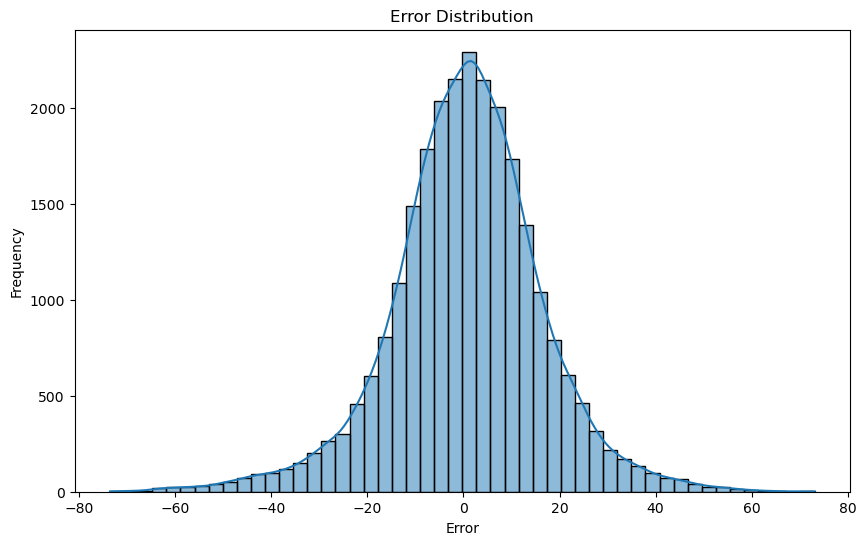

In [89]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(final_result['number_sold'] - final_result['predicted_number_sold'], bins=50, kde=True)
plt.title("Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()